# Semi-Supervised Learning with Deep Generative Models

https://arxiv.org/abs/1406.5298

http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

https://github.com/tensorflow/probability/blob/v0.7/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tf.get_logger().setLevel("ERROR")

print("TensorFlow", tf.__version__)
print("TensorFlow Probability", tfp.__version__)
print("TensorFlow Datasets", tfds.version.__version__)
print("GPU Available:", tf.test.gpu_device_name())

TensorFlow 2.0.0-beta1
TensorFlow Probability 0.7.0
TensorFlow Datasets 1.0.2
GPU Available: /device:GPU:0


In [2]:
%matplotlib inline

sns.set(rc={"figure.figsize": (12, 8)})

In [3]:
def display_model(model, **kvargs):
    dot = tf.keras.utils.model_to_dot(model, show_shapes=True, dpi=72, **kvargs)
    svg = dot.create(prog="dot", format="svg")
    display(SVG(svg))

In [4]:
from IPython.display import SVG

def display_images(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation="none", cmap="gray")
        axs.flat[i].axis("off")
    plt.show()
    plt.close()
    plt.ion()

In [5]:
def load_mnist(preprocess_fn, batch_size=256, buffer_size=2014, as_supervised=True):
    datasets, datasets_info = tfds.load(name="mnist",
                                        with_info=True,
                                        as_supervised=as_supervised)

    train_dataset = datasets["train"] \
                        .prefetch(tf.data.experimental.AUTOTUNE) \
                        .map(preprocess_fn) \
                        .shuffle(buffer_size) \
                        .batch(batch_size)

    eval_dataset = datasets["test"] \
                        .prefetch(tf.data.experimental.AUTOTUNE) \
                        .map(preprocess_fn) \
                        .batch(batch_size)
    
    return train_dataset, eval_dataset, datasets_info

## Classifier

In [6]:
tf.keras.backend.clear_session()

In [7]:
def _preprocess(images, labels):
    images = tf.cast(images, tf.float32) / 255.  # Scale to unit interval.
    return images, labels

train_dataset, eval_dataset, datasets_info = load_mnist(_preprocess)

print(datasets_info.features)
print("Train:", train_dataset)
print("Test :", eval_dataset)

FeaturesDict({'image': Image(shape=(28, 28, 1), dtype=tf.uint8), 'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)})
Train: <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>
Test : <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>


In [8]:
input_shape = datasets_info.features["image"].shape
num_classes = datasets_info.features["label"].num_classes
hidden_size = 500

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
re_lu (ReLU)                 (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5010      
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________


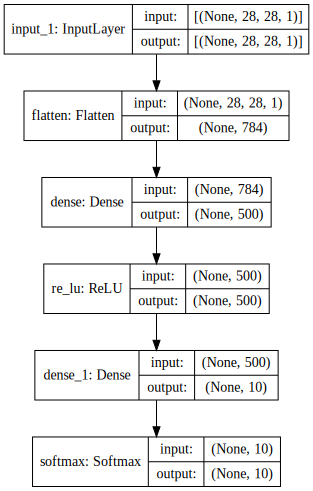

In [9]:
def create_classifier(input_shape, hidden_size, num_classes):
    return tf.keras.models.Sequential(
        name="classifier",
        layers=[
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=hidden_size),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(units=num_classes),
            tf.keras.layers.Softmax(),
        ])

classifier = create_classifier(input_shape, hidden_size, num_classes)

classifier.summary()
display_model(classifier)

Epoch 1/5
235/235 - 15s - loss: 0.3237 - accuracy: 0.9096 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
235/235 - 14s - loss: 0.1383 - accuracy: 0.9606 - val_loss: 0.1219 - val_accuracy: 0.9660
Epoch 3/5
235/235 - 14s - loss: 0.0934 - accuracy: 0.9733 - val_loss: 0.1003 - val_accuracy: 0.9727
Epoch 4/5
235/235 - 14s - loss: 0.0686 - accuracy: 0.9804 - val_loss: 0.0825 - val_accuracy: 0.9761
Epoch 5/5
235/235 - 14s - loss: 0.0525 - accuracy: 0.9851 - val_loss: 0.0791 - val_accuracy: 0.9776


[0.07907061940059065, 0.9776]

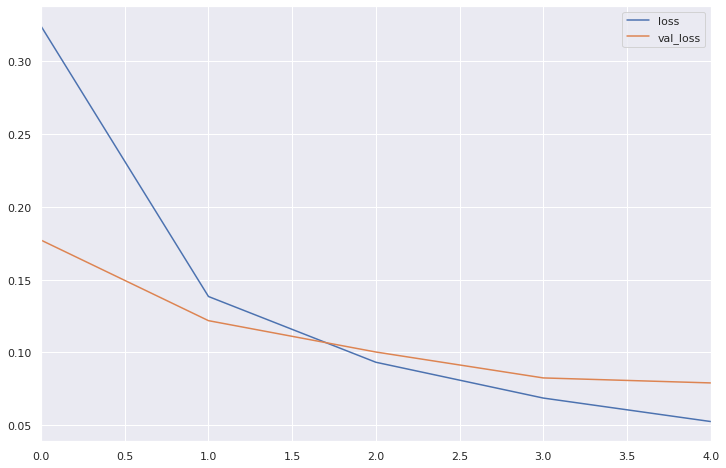

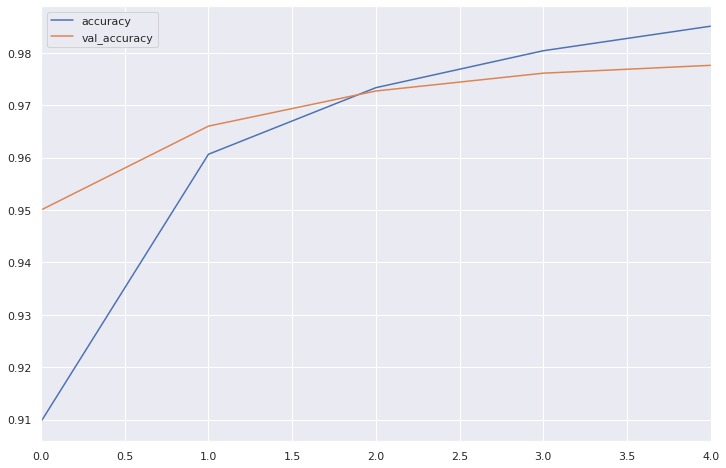

In [10]:
classifier.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.metrics.SparseCategoricalAccuracy("accuracy")])

history = classifier.fit(train_dataset,
                         validation_data=eval_dataset,
                         epochs=5,
                         verbose=2)

log = pd.DataFrame(history.history)
log[["loss", "val_loss"]].plot()
log[["accuracy", "val_accuracy"]].plot()

classifier.evaluate(eval_dataset, verbose=2)

## Autoencoder

In [11]:
tf.keras.backend.clear_session()

In [12]:
def _preprocess(sample):
    image = tf.cast(sample["image"], tf.float32) / 255.  # Scale to unit interval.
    image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
    return image, image

train_dataset, eval_dataset, datasets_info = load_mnist(_preprocess, as_supervised=False)

print(datasets_info.features)
print("Train:", train_dataset)
print("Test :", eval_dataset)

FeaturesDict({'image': Image(shape=(28, 28, 1), dtype=tf.uint8), 'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)})
Train: <BatchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.bool, tf.bool)>
Test : <BatchDataset shapes: ((None, 28, 28, 1), (None, 28, 28, 1)), types: (tf.bool, tf.bool)>


In [13]:
input_shape = datasets_info.features["image"].shape
hidden_size = 500
encoded_size = 50

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               392500    
_________________________________________________________________
re_lu (ReLU)                 (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1325)              663825    
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 50), (None, 50))  0         
Total params: 1,056,325
Trainable params: 1,056,325
Non-trainable params: 0
_________________________________________________

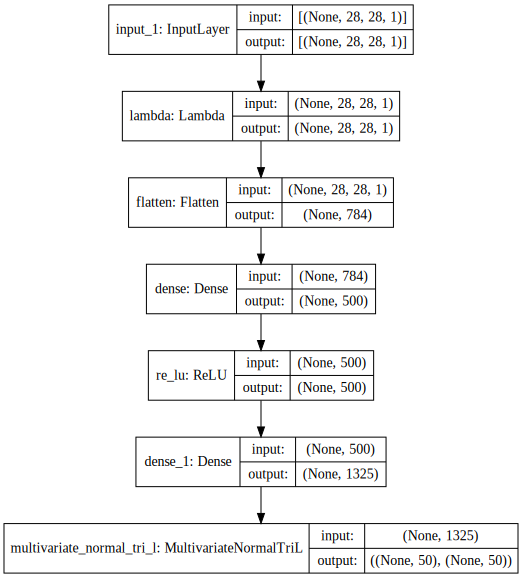

In [14]:
def create_prior(encoded_size):
    # loc = mean, scale = std
    prior = tfp.distributions.Normal(loc=tf.zeros(encoded_size), scale=1)
    prior = tfp.distributions.Independent(prior, reinterpreted_batch_ndims=1)
    return prior

def create_encoder(input_shape, hidden_size, encoded_size, prior):
    params_size = tfp.layers.MultivariateNormalTriL.params_size(encoded_size)
    kld_loss = tfp.layers.KLDivergenceRegularizer(prior)
    return tf.keras.models.Sequential(
        name="encoder",
        layers=[
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=hidden_size),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(units=params_size),
            tfp.layers.MultivariateNormalTriL(
                event_size=encoded_size,
                activity_regularizer=kld_loss),
        ])

prior = create_prior(encoded_size)
encoder = create_encoder(input_shape, hidden_size, encoded_size, prior)

encoder.summary()
display_model(encoder)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               25500     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               392784    
_________________________________________________________________
independent_bernoulli (Indep ((None, 28, 28, 1), (None 0         
Total params: 418,284
Trainable params: 418,284
Non-trainable params: 0
_________________________________________________________________


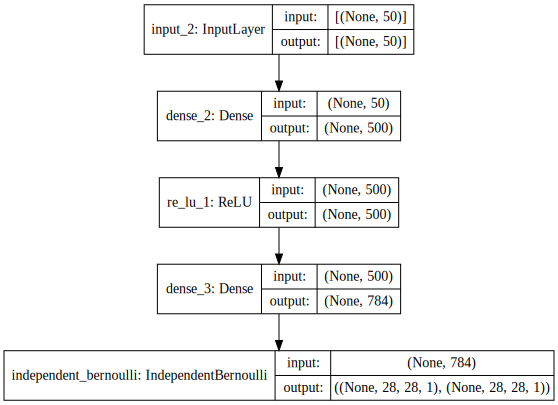

In [15]:
def create_decoder(encoded_size, hidden_size, output_shape):
    params_size = np.prod(output_shape)
    return tf.keras.models.Sequential(
        name="decoder",
        layers=[
            tf.keras.layers.InputLayer(input_shape=[encoded_size]),
            tf.keras.layers.Dense(units=hidden_size),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(units=params_size),
            tfp.layers.IndependentBernoulli(output_shape, tfp.distributions.Bernoulli.logits),
        ])

decoder = create_decoder(encoded_size, hidden_size, input_shape)

decoder.summary()
display_model(decoder)

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Sequential)         (None, 50)                1056325   
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         418284    
Total params: 1,474,609
Trainable params: 1,474,609
Non-trainable params: 0
_________________________________________________________________


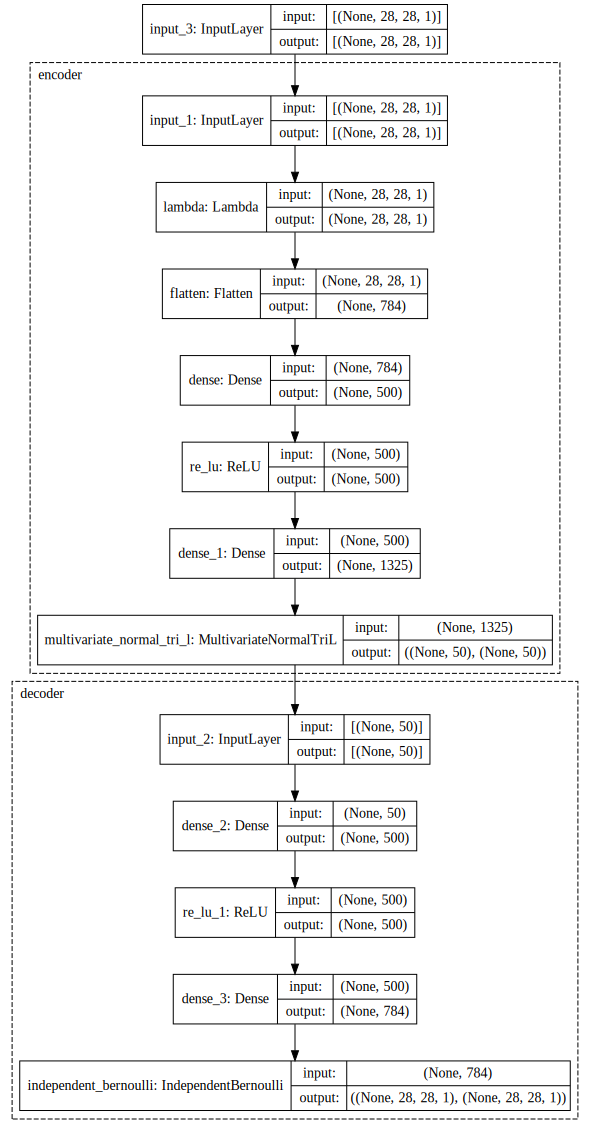

In [16]:
def create_autoencoder(encoder, decoder):
    vae_x = tf.keras.layers.Input(shape=input_shape)
    vae_z = encoder(vae_x)
    vae_x_hat = decoder(vae_z)

    vae = tf.keras.models.Model(name="VAE",
                                inputs=vae_x,
                                outputs=vae_x_hat)

    return vae

vae = create_autoencoder(encoder, decoder)

vae.summary()
display_model(vae, expand_nested=True)

Epoch 1/10
235/235 - 25s - loss: 221.3900 - accuracy: 0.8411 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
235/235 - 24s - loss: 191.4135 - accuracy: 0.8704 - val_loss: 183.6007 - val_accuracy: 0.8800
Epoch 3/10
235/235 - 23s - loss: 180.0846 - accuracy: 0.8813 - val_loss: 172.6162 - val_accuracy: 0.8919
Epoch 4/10
235/235 - 22s - loss: 168.8639 - accuracy: 0.8942 - val_loss: 164.9114 - val_accuracy: 0.9001
Epoch 5/10
235/235 - 22s - loss: 161.6148 - accuracy: 0.9016 - val_loss: 158.1958 - val_accuracy: 0.9060
Epoch 6/10
235/235 - 27s - loss: 156.2476 - accuracy: 0.9072 - val_loss: 153.2495 - val_accuracy: 0.9123
Epoch 7/10
235/235 - 25s - loss: 151.9029 - accuracy: 0.9120 - val_loss: 150.4279 - val_accuracy: 0.9139
Epoch 8/10
235/235 - 22s - loss: 149.6734 - accuracy: 0.9140 - val_loss: 148.5301 - val_accuracy: 0.9171
Epoch 9/10
235/235 - 22s - loss: 148.1320 - accuracy: 0.9153 - val_loss: 147.1641 - val_accuracy: 0.9167
Epoch 10/10
235/235 - 22s - loss: 146.9563 - accu

[145.55777969360352, 0.9192593]

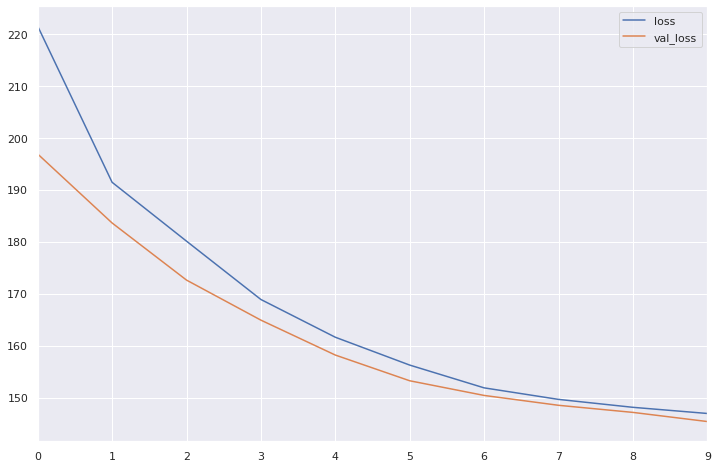

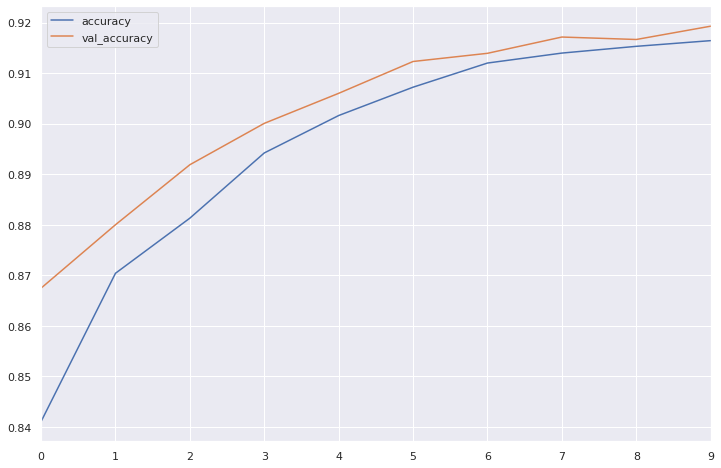

In [17]:
def negative_log_likelihood(x, x_hat):
    # x_hat is a Random Variable
    return -x_hat.log_prob(x)

vae.compile(
    optimizer=tf.optimizers.Adam(),
    loss=negative_log_likelihood,
    metrics=[tf.metrics.BinaryAccuracy("accuracy")])

history = vae.fit(train_dataset,
                  validation_data=eval_dataset,
                  epochs=10,
                  verbose=2)

log = pd.DataFrame(history.history)
log[["loss", "val_loss"]].plot()
log[["accuracy", "val_accuracy"]].plot()

vae.evaluate(eval_dataset, verbose=2)

Originals:


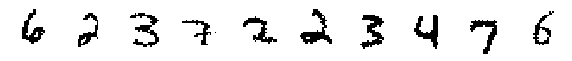

Decoded Random Samples:


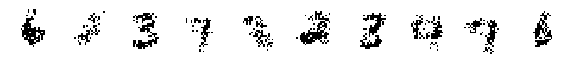

Decoded Modes:


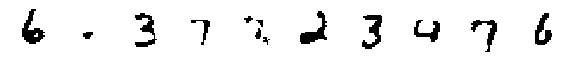

Decoded Means:


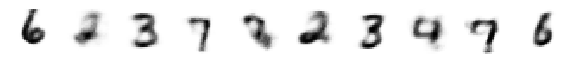

Randomly Generated Samples:


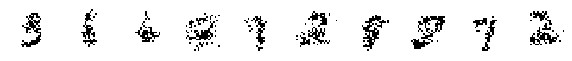

Randomly Generated Modes:


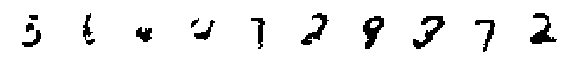

Randomly Generated Means:


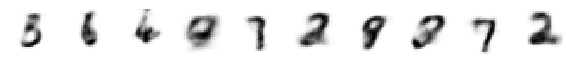

In [18]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
x_hat = vae(x)
assert isinstance(x_hat, tfp.distributions.Distribution)

print("Originals:")
display_images(x)

print("Decoded Random Samples:")
display_images(x_hat.sample())

print("Decoded Modes:")
display_images(x_hat.mode())

print("Decoded Means:")
display_images(x_hat.mean())

# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
x_tilde = decoder(z)
assert isinstance(x_tilde, tfp.distributions.Distribution)

print("Randomly Generated Samples:")
display_images(x_tilde.sample())

print("Randomly Generated Modes:")
display_images(x_tilde.mode())

print("Randomly Generated Means:")
display_images(x_tilde.mean())

## Semi-supervised Learning

**Latent-feature discriminative model (M1)**

In [19]:
tf.keras.backend.clear_session()

In [20]:
def _preprocess(images, labels):
    images = tf.cast(images, tf.float32) / 255.             # Scale to unit interval.
    images = images < tf.random.uniform(tf.shape(images))   # Randomly binarize.
    return {"input": images}, {"decoder": images, "classifier": labels}

train_dataset, eval_dataset, datasets_info = load_mnist(_preprocess)

print(datasets_info.features)
print("Train:", train_dataset)
print("Test :", eval_dataset)

FeaturesDict({'image': Image(shape=(28, 28, 1), dtype=tf.uint8), 'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)})
Train: <BatchDataset shapes: ({input: (None, 28, 28, 1)}, {decoder: (None, 28, 28, 1), classifier: (None,)}), types: ({input: tf.bool}, {decoder: tf.bool, classifier: tf.int64})>
Test : <BatchDataset shapes: ({input: (None, 28, 28, 1)}, {decoder: (None, 28, 28, 1), classifier: (None,)}), types: ({input: tf.bool}, {decoder: tf.bool, classifier: tf.int64})>


In [21]:
input_shape = datasets_info.features["image"].shape
num_classes = datasets_info.features["label"].num_classes
hidden_size = 500
encoded_size = 50

Model: "VAE-M1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Sequential)            (None, 50)           1056325     input[0][0]                      
__________________________________________________________________________________________________
decoder (Sequential)            (None, 28, 28, 1)    418284      encoder[1][0]                    
__________________________________________________________________________________________________
classifier (Sequential)         (None, 10)           30510       encoder[1][0]                    
Total params: 1,505,119
Trainable params: 1,505,119
Non-trainable params: 0
_________________

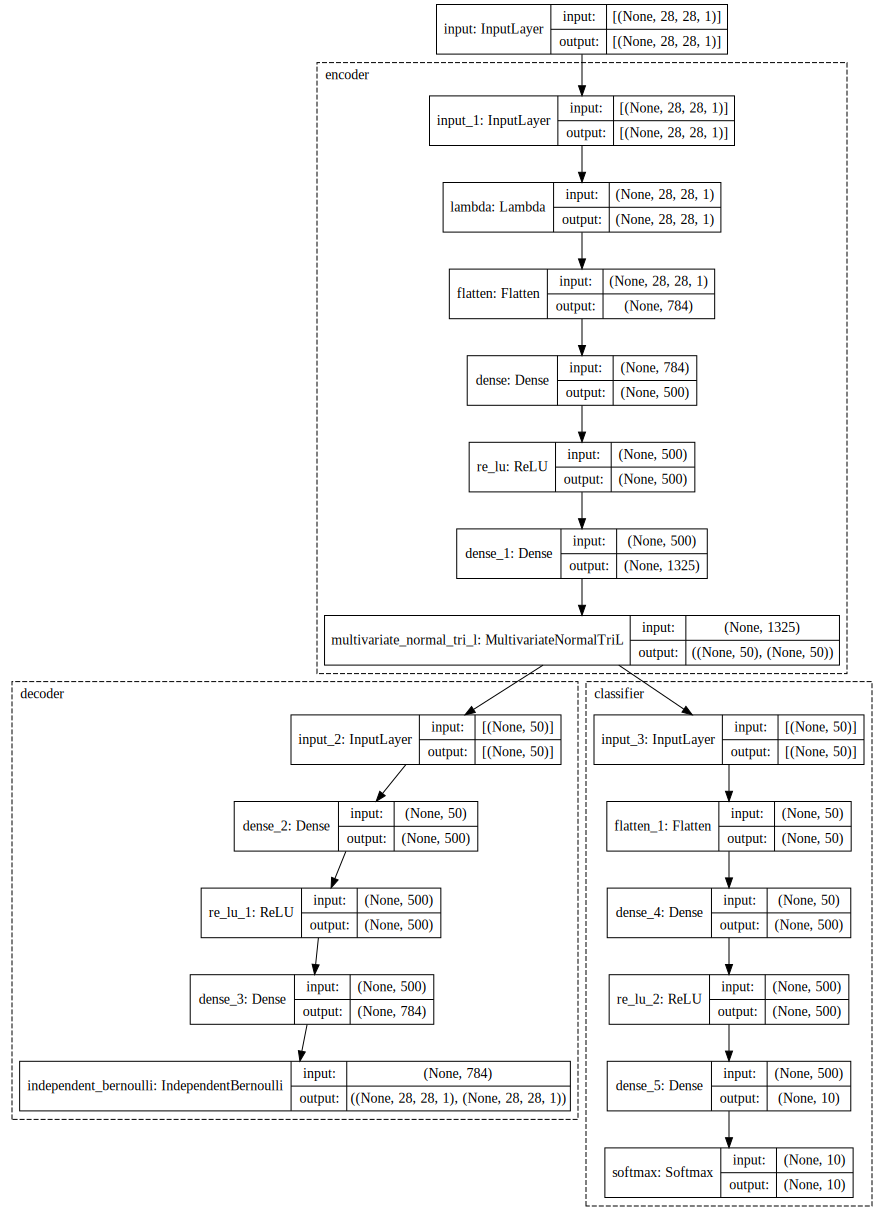

In [22]:
def create_autoencoder_m1(encoder, decoder, classifier):
    vae_x = tf.keras.layers.Input(shape=input_shape, name="input")
    vae_z = encoder(vae_x)
    vae_x_hat = decoder(vae_z)
    vae_y_hat = classifier(vae_z)

    vae = tf.keras.models.Model(name="VAE-M1",
                                inputs=vae_x,
                                outputs=[vae_x_hat, vae_y_hat])
    
    return vae

prior = create_prior(encoded_size)
encoder = create_encoder(input_shape, hidden_size, encoded_size, prior)
decoder = create_decoder(encoded_size, hidden_size, input_shape)
classifier = create_classifier([encoded_size], hidden_size, num_classes)
vae_m1 = create_autoencoder_m1(encoder, decoder, classifier)

vae_m1.summary()
display_model(vae_m1, expand_nested=True)

Epoch 1/10
235/235 - 26s - loss: 221.5006 - decoder_loss: 211.9845 - decoder_accuracy: 0.8411 - val_loss: 0.0000e+00 - val_decoder_loss: 0.0000e+00 - val_decoder_accuracy: 0.0000e+00
Epoch 2/10
235/235 - 23s - loss: 189.2304 - decoder_loss: 182.1881 - decoder_accuracy: 0.8727 - val_loss: 182.0740 - val_decoder_loss: 173.9967 - val_decoder_accuracy: 0.8813
Epoch 3/10
235/235 - 23s - loss: 175.8990 - decoder_loss: 166.6982 - decoder_accuracy: 0.8859 - val_loss: 169.7363 - val_decoder_loss: 159.2141 - val_decoder_accuracy: 0.8942
Epoch 4/10
235/235 - 23s - loss: 166.5414 - decoder_loss: 155.3936 - decoder_accuracy: 0.8958 - val_loss: 162.2289 - val_decoder_loss: 150.0346 - val_decoder_accuracy: 0.9021
Epoch 5/10
235/235 - 25s - loss: 159.4685 - decoder_loss: 146.3502 - decoder_accuracy: 0.9037 - val_loss: 156.4215 - val_decoder_loss: 142.8246 - val_decoder_accuracy: 0.9072
Epoch 6/10
235/235 - 28s - loss: 153.7124 - decoder_loss: 138.7555 - decoder_accuracy: 0.9102 - val_loss: 151.0917 - 

[142.2797119140625, 123.63236, 0.9226925]

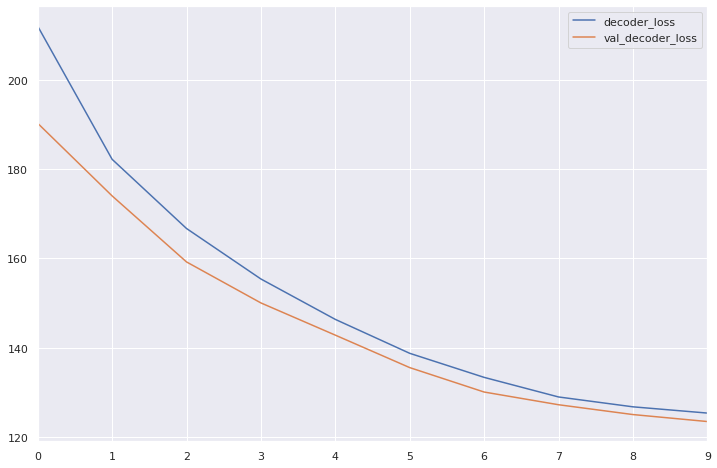

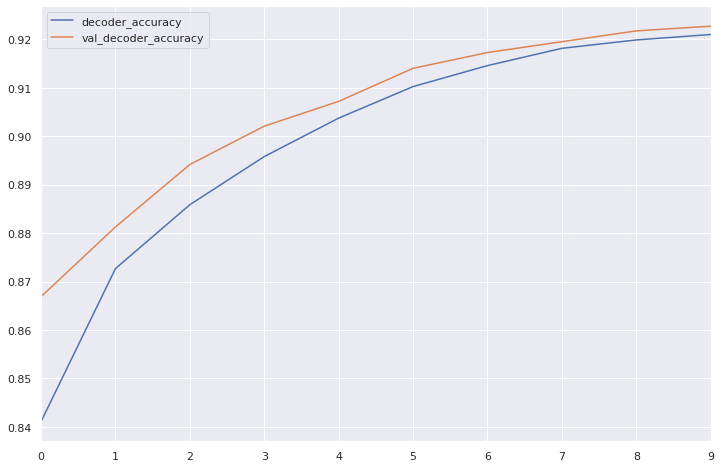

In [23]:
classifier.trainable = False

vae_m1.compile(
    optimizer=tf.optimizers.Adam(),
    loss={"decoder": negative_log_likelihood},
    metrics={"decoder": [tf.metrics.BinaryAccuracy("accuracy")]})

history = vae_m1.fit(train_dataset,
                     validation_data=eval_dataset,
                     epochs=10,
                     verbose=2)

log = pd.DataFrame(history.history)
log[["decoder_loss", "val_decoder_loss"]].plot()
log[["decoder_accuracy", "val_decoder_accuracy"]].plot()

vae_m1.evaluate(eval_dataset, verbose=2)

Epoch 1/5
235/235 - 19s - loss: 19.5327 - classifier_loss: 0.9421 - classifier_accuracy: 0.6949 - val_loss: 0.0000e+00 - val_classifier_loss: 0.0000e+00 - val_classifier_accuracy: 0.0000e+00
Epoch 2/5
235/235 - 17s - loss: 19.2509 - classifier_loss: 0.6613 - classifier_accuracy: 0.7692 - val_loss: 19.2725 - val_classifier_loss: 0.6190 - val_classifier_accuracy: 0.7862
Epoch 3/5
235/235 - 17s - loss: 19.1977 - classifier_loss: 0.6056 - classifier_accuracy: 0.7883 - val_loss: 19.3260 - val_classifier_loss: 0.5808 - val_classifier_accuracy: 0.7977
Epoch 4/5
235/235 - 17s - loss: 19.1784 - classifier_loss: 0.5841 - classifier_accuracy: 0.7940 - val_loss: 19.2419 - val_classifier_loss: 0.5709 - val_classifier_accuracy: 0.8020
Epoch 5/5
235/235 - 17s - loss: 19.1411 - classifier_loss: 0.5677 - classifier_accuracy: 0.7997 - val_loss: 19.1952 - val_classifier_loss: 0.5588 - val_classifier_accuracy: 0.8069


[19.262272596359253, 0.5531851, 0.8046]

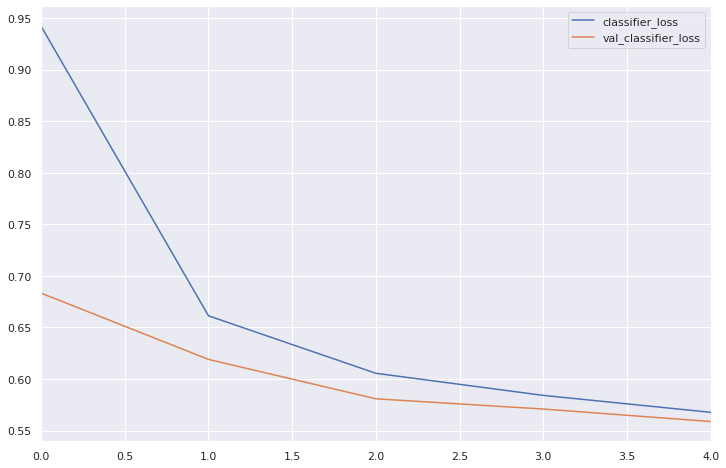

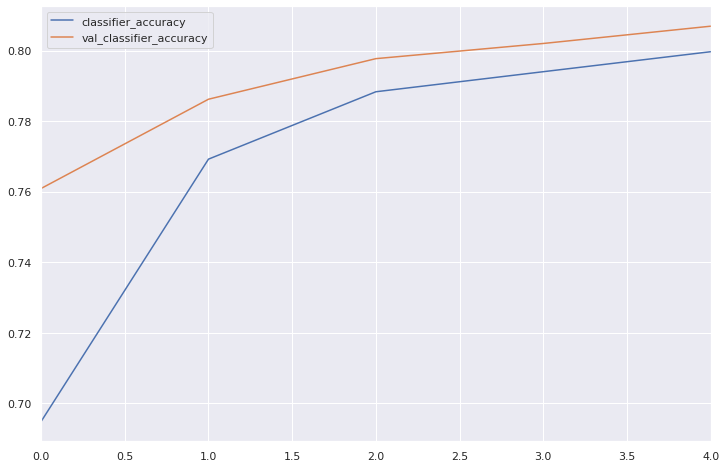

In [24]:
encoder.trainable = False
decoder.trainable = False
classifier.trainable = True

vae_m1.compile(
    optimizer=tf.optimizers.Adam(),
    loss={"classifier": tf.losses.SparseCategoricalCrossentropy()},
    metrics={"classifier": [tf.metrics.SparseCategoricalAccuracy("accuracy")]})

history = vae_m1.fit(train_dataset,
                     validation_data=eval_dataset,
                     epochs=5,
                     verbose=2)

log = pd.DataFrame(history.history)
log[["classifier_loss", "val_classifier_loss"]].plot()
log[["classifier_accuracy", "val_classifier_accuracy"]].plot()

vae_m1.evaluate(eval_dataset, verbose=2)

Originals:


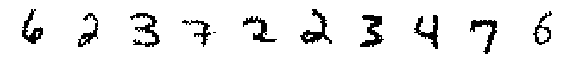

Decoded Random Samples:


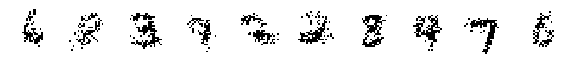

Decoded Modes:


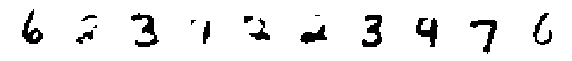

Decoded Means:


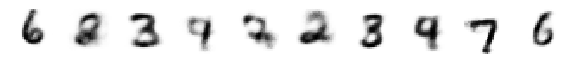

Randomly Generated Samples:


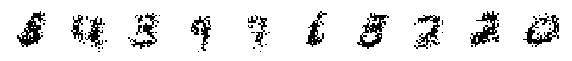

Randomly Generated Modes:


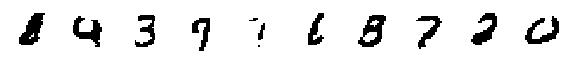

Randomly Generated Means:


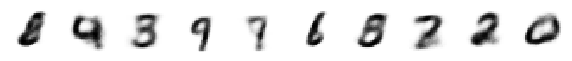

In [25]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0]["input"][:10]
x_hat = vae_m1(x)[0]
assert isinstance(x_hat, tfp.distributions.Distribution)

print("Originals:")
display_images(x)

print("Decoded Random Samples:")
display_images(x_hat.sample())

print("Decoded Modes:")
display_images(x_hat.mode())

print("Decoded Means:")
display_images(x_hat.mean())

# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
x_tilde = decoder(z)
assert isinstance(x_tilde, tfp.distributions.Distribution)

print("Randomly Generated Samples:")
display_images(x_tilde.sample())

print("Randomly Generated Modes:")
display_images(x_tilde.mode())

print("Randomly Generated Means:")
display_images(x_tilde.mean())

**Generative semi-supervised model (M2)**

Model: "VAE-M2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Sequential)            (None, 50)           1056325     input[0][0]                      
__________________________________________________________________________________________________
classifier (Sequential)         (None, 10)           397510      input[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 60)           0           encoder[1][0]                    
                                                                 classifier[1][0]            

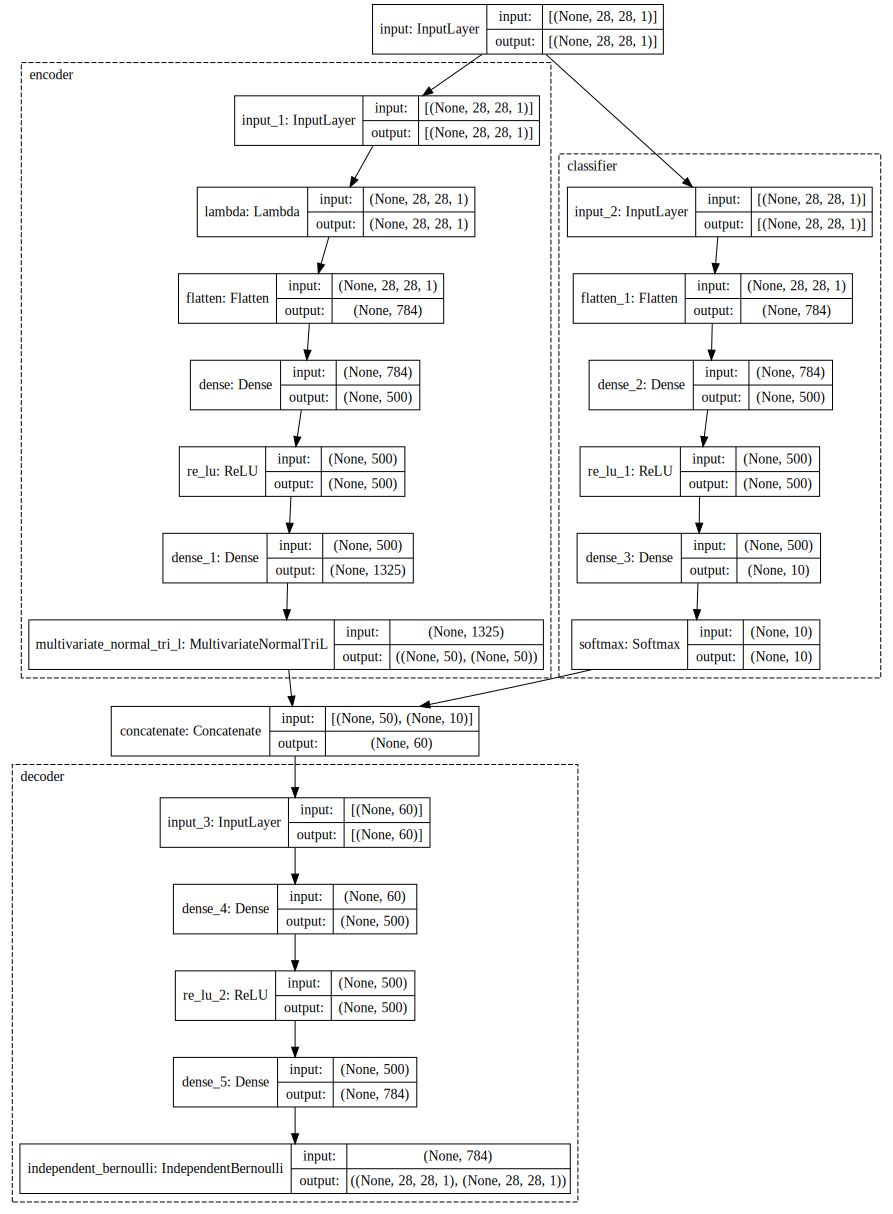

In [26]:
tf.keras.backend.clear_session()

def create_autoencoder_m2(encoder, decoder, classifier):
    vae_x = tf.keras.layers.Input(shape=input_shape, name="input")
    vae_z = encoder(vae_x)
    vae_y = classifier(vae_x)
    vae_zy = tf.keras.layers.Concatenate()([vae_z, vae_y])
    vae_x_hat = decoder(vae_zy)

    vae = tf.keras.models.Model(name="VAE-M2",
                                inputs=vae_x,
                                outputs=vae_x_hat)
    
    return vae

train_dataset, eval_dataset, datasets_info = load_mnist(_preprocess)
input_shape = datasets_info.features["image"].shape
num_classes = datasets_info.features["label"].num_classes
hidden_size = 500
encoded_size = 50

prior = create_prior(encoded_size)
encoder = create_encoder(input_shape, hidden_size, encoded_size, prior)
classifier = create_classifier(input_shape, hidden_size, num_classes)
decoder = create_decoder(encoded_size + num_classes, hidden_size, input_shape)
vae_m2 = create_autoencoder_m2(encoder, decoder, classifier)

vae_m2.summary()
display_model(vae_m2, expand_nested=True)